In [205]:
!pip install chart_studio

In [206]:
!pip install pyramid
!pip install pmdarima


In [292]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go
import xgboost as xgb
import keras.backend as K
import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
#from pyramid.arima import auto_arima
from pmdarima.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, TimeDistributed, Dense, RepeatVector, Dropout
#from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import regularizers

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [208]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [209]:
# Read dataset

%%time
file_path = 'data.csv'

try:
    df = pd.read_csv(file_path, delimiter=',')
except pd.errors.ParserError as e:
    print(f'Error while parsing CSV file: {e}')

CPU times: user 2.2 s, sys: 113 ms, total: 2.32 s
Wall time: 2.9 s


<timed exec>:4: DtypeWarning: Columns (5,7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.


In [210]:
df.head()

,Delivery Number,Delivery Type Code,Delivery DateTime,Planned Good Issued Date,Sales Organization Category,Shipping Condition Code,Shipping Plant Number,Ship to Customer,Sold to Customer,Actual Good Issue Date,Initial Commercial Code,Sales Organization Number,Pick Date,Group Code
0,3800332504,ZTLD,"Monday, January 13, 2020","Monday, January 13, 2020",T,99,ZA08,30221722,30221722,"Monday, January 13, 2020",CIF,ZA01,"Monday, January 13, 2020",8030
1,3102483284,ZTLD,"Thursday, July 9, 2020","Thursday, July 9, 2020",T,99,FRV7,30151981,30151981,"Wednesday, July 8, 2020",DAP,FR01,"Thursday, July 9, 2020",8030
2,3601790096,ZTLD,"Thursday, February 13, 2020","Thursday, February 13, 2020",T,99,ES08,30101906,30101906,"Tuesday, February 18, 2020",CIP,ES01,"Thursday, February 13, 2020",8030
3,3052029572,ZTLD,"Wednesday, November 11, 2020","Wednesday, November 11, 2020",T,99,DE38,30014613,30014613,"Tuesday, November 3, 2020",CIP,DE01,"Wednesday, November 11, 2020",8030
4,3001601788,RL,"Sunday, July 12, 2020","Sunday, July 12, 2020",J,1,ES05,39003699,#VALUE!,"Thursday, May 7, 2020",FCA,CH01,"Sunday, July 12, 2020",


In [211]:
# Drop whitespace of column names

def remove_whitespace(df):
    df.columns = df.columns.str.strip().str.replace(' ', '')

    # return new dataframe and new column names
    return df

In [212]:
# Call Dataframe and drop white spaces
df = remove_whitespace(df)

In [213]:
# Convert date columns
date_columns = ['DeliveryDateTime', 'PlannedGoodIssuedDate', 'ActualGoodIssueDate', 'PickDate']
for col in date_columns:
  df[col] = pd.to_datetime(df[col])
df.head()

,DeliveryNumber,DeliveryTypeCode,DeliveryDateTime,PlannedGoodIssuedDate,SalesOrganizationCategory,ShippingConditionCode,ShippingPlantNumber,ShiptoCustomer,SoldtoCustomer,ActualGoodIssueDate,InitialCommercialCode,SalesOrganizationNumber,PickDate,GroupCode
0,3800332504,ZTLD,2020-01-13,2020-01-13,T,99,ZA08,30221722,30221722,2020-01-13,CIF,ZA01,2020-01-13,8030
1,3102483284,ZTLD,2020-07-09,2020-07-09,T,99,FRV7,30151981,30151981,2020-07-08,DAP,FR01,2020-07-09,8030
2,3601790096,ZTLD,2020-02-13,2020-02-13,T,99,ES08,30101906,30101906,2020-02-18,CIP,ES01,2020-02-13,8030
3,3052029572,ZTLD,2020-11-11,2020-11-11,T,99,DE38,30014613,30014613,2020-11-03,CIP,DE01,2020-11-11,8030
4,3001601788,RL,2020-07-12,2020-07-12,J,1,ES05,39003699,#VALUE!,2020-05-07,FCA,CH01,2020-07-12,


In [214]:
# Detect null values in 'Date' columns
for col in date_columns:
  print(col)
  null_dates = df[df[col].isnull()]
  print(null_dates.shape)
  print('*************')

DeliveryDateTime
(0, 14)
*************
PlannedGoodIssuedDate
(0, 14)
*************
ActualGoodIssueDate
(0, 14)
*************
PickDate
(629546, 14)
*************


In [215]:
# Missing Value Analyse
def missing_value_analyse(df):
  col_list = df.columns.to_list()
  for col in col_list:
    print('Null values for ', col)
    null_values = df[df[col].isnull()]
    print('Shape of ', col, 'is : ', null_values.shape)

    print('Whitespace values for ', col)
    print('Shape of ', col, 'is : ', df[df[col] == ' '].shape)

    print('*************')

In [216]:
null_value_list = ['PickDate']
white_space_list = ['ShippingConditionCode', 'ShippingPlantNumber', 'InitialCommercialCode', 'SalesOrganizationNumber', 'GroupCode']

In [217]:
# Missing value imputation
df['ShippingConditionCode'] = df['ShippingConditionCode'].replace(' ', '0')
df['ShippingPlantNumber'] = df['ShippingPlantNumber'].replace(' ', 'AA00')
df['InitialCommercialCode'] = df['InitialCommercialCode'].replace(' ', 'Unknown')
df['SalesOrganizationNumber'] = df['SalesOrganizationNumber'].replace(' ', 'AA00')
df['GroupCode'] = df['GroupCode'].replace(' ', '0000')

In [218]:
df[df.DeliveryDateTime == '2020-12-26'].shape, df[df.DeliveryDateTime == '2020-12-25'].shape

((32, 14), (277, 14))

In [219]:
%%time
delivery_count = df['DeliveryDateTime'].value_counts().reset_index()
delivery_count = delivery_count.sort_values(by='DeliveryDateTime', ascending=True)
delivery_count.columns = ['DeliveryDateTime', 'Count']

CPU times: user 13.4 ms, sys: 151 µs, total: 13.5 ms
Wall time: 16.1 ms


In [220]:
delivery_count[delivery_count.DeliveryDateTime == '2020-07-01'].head()

,DeliveryDateTime,Count
65,2020-07-01,3150


In [221]:
df[df.DeliveryDateTime == '2020-07-01'].shape

(3150, 14)

In [222]:
delivery_count.set_index('DeliveryDateTime', inplace=True)

In [223]:
delivery_count.head()

,Count
DeliveryDateTime,
2020-01-01,14
2020-01-05,20
2020-12-26,32
2020-04-12,48
2020-01-12,51


In [224]:
delivery_count = delivery_count.sort_index()
delivery_count.head()

,Count
DeliveryDateTime,
2020-01-01,14
2020-01-02,191
2020-01-03,285
2020-01-04,62
2020-01-05,20


<Axes: xlabel='DeliveryDateTime'>

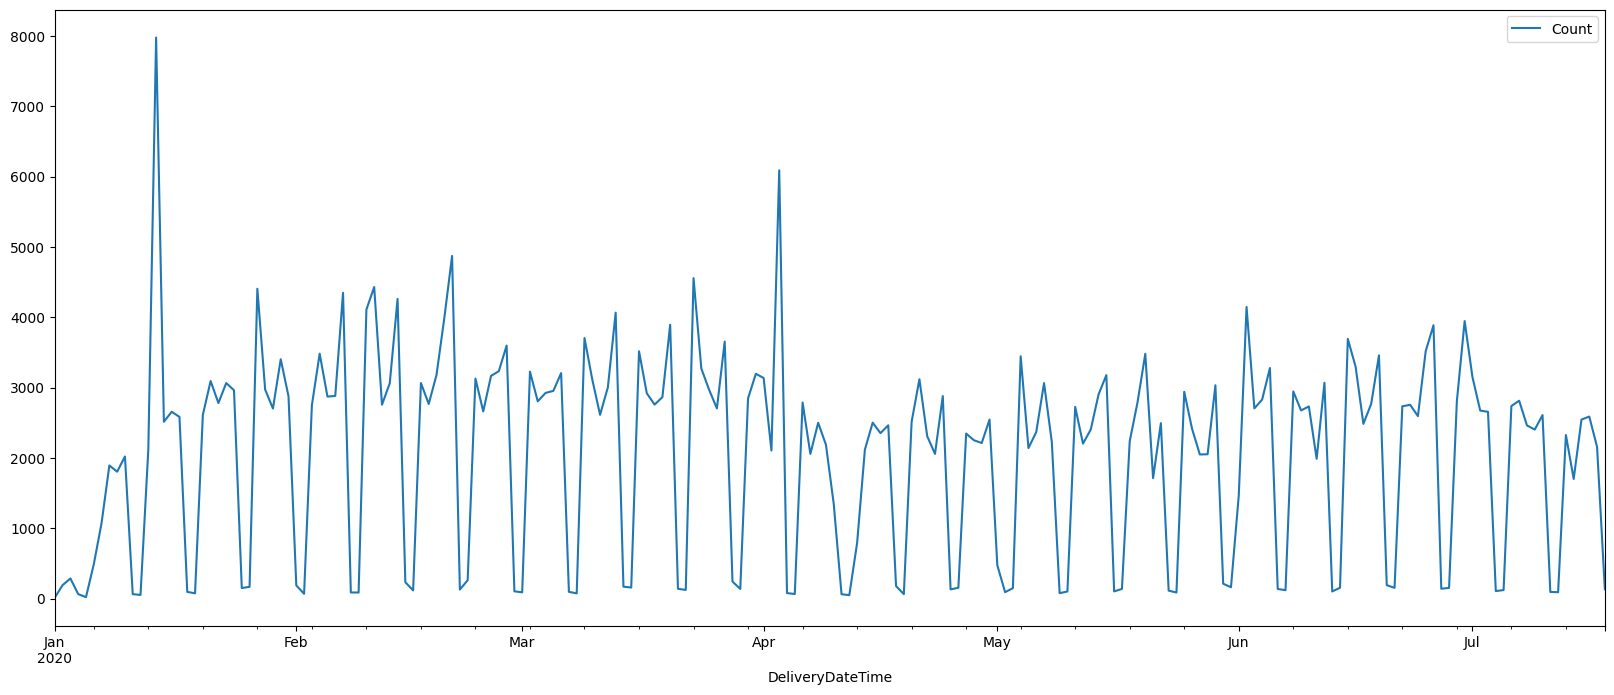

In [225]:
#Plot data
delivery_count.iloc[:200].plot(figsize=(20,8))

In [226]:
#Stationary Control
#if P-Value is smaller than 0.005, we can say that there is stationary, else there is no stationary
#if our data has no stationary, I will plan to use differences

class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Dickey-Fuller test:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Add Critical Values
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [227]:
sTest = Stationary()


In [228]:
sTest.ADF_Stationarity_Test(delivery_count['Count'])
print(sTest.isStationary)

DeliveryDateTime
2020-01-01      14
2020-01-02     191
2020-01-03     285
2020-01-04      62
2020-01-05      20
              ... 
2020-12-27      67
2020-12-28    1977
2020-12-29    1062
2020-12-30    1111
2020-12-31    1715
Name: Count, Length: 366, dtype: int64
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.207160
P-Value                   0.203657
# Lags Used              13.000000
# Observations Used     352.000000
Critical Value (1%)      -3.449065
Critical Value (5%)      -2.869786
Critical Value (10%)     -2.571163
dtype: float64
False


In [229]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [230]:
#diff_values = difference(delivery_count['Count'], 1)
diff_values = pd.Series(delivery_count['Count'])



In [231]:
def clip_outliers(series, sigma=1.5):
    """
    Limits the outliers in the given series based on a specified sigma value.

    Parameters:
    - series: Pandas Series, the data to be clipped.
    - sigma: float, the sigma value used to limit the outliers. Default is 1.5.

    Returns:
    - Pandas Series, the clipped data.
    """
    series_mean = series.mean()
    series_std = series.std()
    lower_bound = series_mean - sigma * series_std
    upper_bound = series_mean + sigma * series_std
    return series.clip(lower=lower_bound, upper=upper_bound)

In [232]:
diff_values = clip_outliers(diff_values, sigma=1.5)


In [233]:

# split train test datasets
xtrain, xtest = diff_values[0:-7], diff_values[-7:]

In [234]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [235]:
# scale train and test data to [-1, 1] with MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()

    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)

    return scaler, tr_scaled, ts_scaled

In [236]:

# reorganize dataset acording to window size
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [237]:
supervised_raw


,0 (t-12),0 (t-11),0 (t-10),0 (t-9),0 (t-8),0 (t-7),0 (t-6),0 (t-5),0 (t-4),0 (t-3),0 (t-2),0 (t-1),0 (t-0)
12,14.0,191.0,285.0,62.0,20.0,487.0,1074.0,1892.0,1803.0,2019.000000,62.000000,51.000000,2117.000000
13,191.0,285.0,62.0,20.0,487.0,1074.0,1892.0,1803.0,2019.0,62.000000,51.000000,2117.000000,4157.838557
14,285.0,62.0,20.0,487.0,1074.0,1892.0,1803.0,2019.0,62.0,51.000000,2117.000000,4157.838557,2513.000000
15,62.0,20.0,487.0,1074.0,1892.0,1803.0,2019.0,62.0,51.0,2117.000000,4157.838557,2513.000000,2655.000000
16,20.0,487.0,1074.0,1892.0,1803.0,2019.0,62.0,51.0,2117.0,4157.838557,2513.000000,2655.000000,2582.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2813.0,2110.0,2564.0,4093.0,140.0,158.0,2017.0,2384.0,2280.0,2440.000000,277.000000,32.000000,67.000000
362,2110.0,2564.0,4093.0,140.0,158.0,2017.0,2384.0,2280.0,2440.0,277.000000,32.000000,67.000000,1977.000000
363,2564.0,4093.0,140.0,158.0,2017.0,2384.0,2280.0,2440.0,277.0,32.000000,67.000000,1977.000000,1062.000000
364,4093.0,140.0,158.0,2017.0,2384.0,2280.0,2440.0,277.0,32.0,67.000000,1977.000000,1062.000000,1111.000000


In [238]:
supervised_raw = supervised_raw.values.astype("float32")


In [239]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))


In [240]:
values_scaled = np.concatenate((train_scaled, test_scaled))


In [241]:
supervised = timeseries_to_supervised(values_scaled, 7)

supervised_values = supervised.values.astype('float32')

##split supervised data into train and test-sets
supervised_train, supervised_test = supervised_raw[0:-7], supervised_raw[-7:]
train_scaled, test_scaled = supervised_values[0:-7], supervised_values[-7:]

In [242]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [243]:
train_y.reshape(train_y.shape[0], 1)


array([[0.453203  ],
       [0.43172532],
       [0.4838509 ],
       [0.01158346],
       [0.00892892],
       [0.50750047],
       [1.        ],
       [0.60306406],
       [0.6373318 ],
       [0.6197153 ],
       [0.01930577],
       [0.01447933],
       [0.6264723 ],
       [0.74278957],
       [0.6672557 ],
       [0.7357912 ],
       [0.71117634],
       [0.03257849],
       [0.03668097],
       [1.        ],
       [0.71358955],
       [0.6484326 ],
       [0.8175994 ],
       [0.69042265],
       [0.04150741],
       [0.01279007],
       [0.6597747 ],
       [0.83666384],
       [0.68945736],
       [0.6916293 ],
       [1.        ],
       [0.01737519],
       [0.01713387],
       [0.98797286],
       [1.        ],
       [0.661464  ],
       [0.7353086 ],
       [1.        ],
       [0.0523669 ],
       [0.02437354],
       [0.73603255],
       [0.6641185 ],
       [0.7637846 ],
       [0.9582902 ],
       [1.        ],
       [0.0272694 ],
       [0.05936525],
       [0.751

In [244]:
# prepare train dataset for lstm
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [245]:
# prepare test dataset for lstm
train_Y_lstm = train_y.reshape((train_y.shape[0], 1, 1))
test_Y_lstm = test_y.reshape((test_y.shape[0], 1, 1))

In [246]:
test_scaled[:, -1]


array([0.06346773, 0.0043438 , 0.01279007, 0.47371536, 0.2529056 ,
       0.2647304 , 0.41048896], dtype=float32)

In [247]:
train_y.shape


(352,)

## ***XGBRegressor***


In [248]:
# XGBRegressor Training
%%time

parameters = { 'gamma' : [0, 0.5, 1], 'learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.35, 0.4],
              'max_depth' : [2, 5, 10, 15, 25],
              'n_estimators' : [10, 25, 50, 75, 100],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[0]	validation_0-rmse:0.25559
[1]	validation_0-rmse:0.20952
[2]	validation_0-rmse:0.17759
[3]	validation_0-rmse:0.15557
[4]	validation_0-rmse:0.14096
[5]	validation_0-rmse:0.13117
[6]	validation_0-rmse:0.12485
[7]	validation_0-rmse:0.12010
[8]	validation_0-rmse:0.11690
[9]	validation_0-rmse:0.11468
[10]	validation_0-rmse:0.11326
[11]	validation_0-rmse:0.11196
[12]	validation_0-rmse:0.11115
[13]	validation_0-rmse:0.11039
[14]	validation_0-rmse:0.10962
[15]	validation_0-rmse:0.10889
[16]	validation_0-rmse:0.10836
[17]	validation_0-rmse:0.10776
[18]	validation_0-rmse:0.10696
[19]	validation_0-rmse:0.10638
[20]	validation_0-rmse:0.10608
[21]	validation_0-rmse:0.10574
[22]	validation_0-rmse:0.10514
[23]	validation_0-rmse:0.10437
[24]	validation_0-rmse:0.10397
[25]	validation_0-rmse:0.10344
[26]	validation_0-rmse:0.10289
[27]	validation_0-rmse:0.10228
[28]	validation_0-rmse:0.10185
[29]	validation_0-rmse:0.10157
[30]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.09880
[40]	validation_0-rmse:0.09880
[41]	validation_0-rmse:0.09880
[42]	validation_0-rmse:0.09880
[43]	validation_0-rmse:0.09880
[44]	validation_0-rmse:0.09880
[45]	validation_0-rmse:0.09880
[46]	validation_0-rmse:0.09880
[47]	validation_0-rmse:0.09880
[48]	validation_0-rmse:0.09880
[49]	validation_0-rmse:0.09880
CPU times: user 8.28 s, sys: 707 ms, total: 8.98 s
Wall time: 2min 18s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.5, 1],
                         'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.35, 0.4],
                         'max_depth': [2, 5, 10, 15, 25],
                         'n_estimators': [10, 25, 50, 75, 100], 'nthread': [-1],
                         'reg_alpha': [1], 'reg_lambda': [1], 'seed': [10]},
             verbose=True)

In [249]:
xgb_grid.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [250]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    # Ensure all elements in new_row are of the same data type
    new_row = [float(x) for x in new_row]  # Convert to float if needed
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    return scaler.inverse_transform(array)[0, -1]


In [251]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [252]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [253]:
#Invert scale predictions to time series
predictions = list()
start = 7 # test period
l = len(test_scaled) - start

rmse = []
mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-7:] # ts_window

    # prediction
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)

    l=l+1

    #yhat = inverse_difference(delivery_count['Count'], yhat, len(test_scaled) + 1 - i) # if not stationary

    predictions.append(yhat)

    rmse.append(sqrt(mean_squared_error([delivery_count['Count'][-7:][i]], [yhat])))
    mape.append(mean_absolute_percentage_error([delivery_count['Count'][-7:][i]], [yhat]))

<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-

In [254]:
print("Test RMSE:", np.mean(rmse))
print("Test MAPE:", np.mean(mape))

Test RMSE: 856.6675224193116
Test MAPE: 205.18958621050956


Test RMSE: 589.8327203830366

Test MAPE: 245.74263642008628
#####

Test RMSE: 678.5173022747034

Test MAPE: 280.28248258443375

In [255]:
result_df = delivery_count[-7:]
result_df.head(10)


,Count
DeliveryDateTime,
2020-12-25,277
2020-12-26,32
2020-12-27,67
2020-12-28,1977
2020-12-29,1062
2020-12-30,1111
2020-12-31,1715


In [256]:
result_df['XGB_Predictions'] = predictions
result_df.head(9)

<ipython-input-256-7abab0c6c09c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['XGB_Predictions'] = predictions


,Count,XGB_Predictions
DeliveryDateTime,,
2020-12-25,277,2409.002137
2020-12-26,32,126.113285
2020-12-27,67,115.104109
2020-12-28,1977,2407.403110
2020-12-29,1062,2440.827553
2020-12-30,1111,2296.751177
2020-12-31,1715,2442.471285


<Axes: xlabel='DeliveryDateTime'>

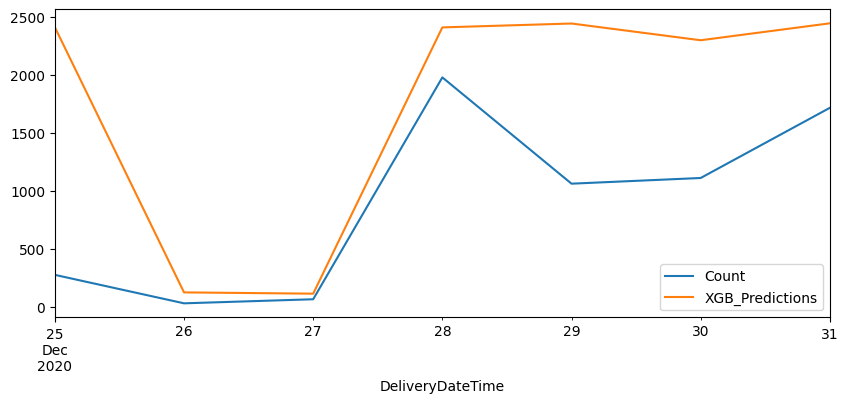

In [257]:
result_df.plot(figsize=(10,4))


## ***Auto Arima***


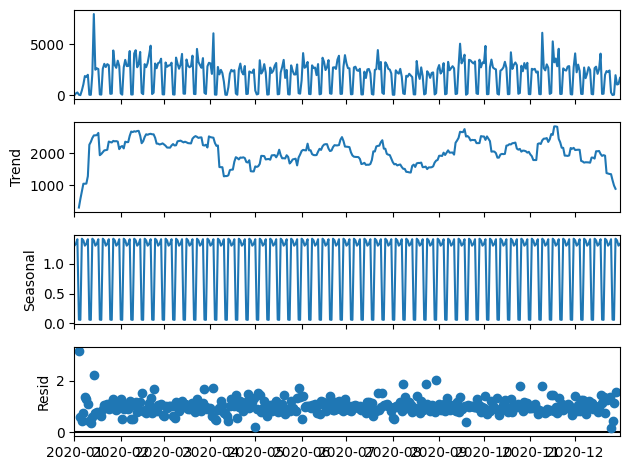

In [258]:
result = seasonal_decompose(delivery_count, model='multiplicative')
fig = result.plot()

In [259]:
arima_train = delivery_count[:-7]

arima_test = delivery_count[-7:]

In [260]:
arima_train.head()

,Count
DeliveryDateTime,
2020-01-01,14
2020-01-02,191
2020-01-03,285
2020-01-04,62
2020-01-05,20


In [261]:
arima_train['Count'] = clip_outliers(arima_train['Count'], sigma=1.5)
arima_train.head()

<ipython-input-261-4cb7b6119639>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_train['Count'] = clip_outliers(arima_train['Count'], sigma=1.5)


,Count
DeliveryDateTime,
2020-01-01,14.0
2020-01-02,191.0
2020-01-03,285.0
2020-01-04,62.0
2020-01-05,20.0


In [262]:
# Arima Training
%%time

arima_stepwise_model = auto_arima(arima_train, start_p=0, start_q=0,
                           max_p=13, max_q=13, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           n_jobs=-1)#n_jobs for parallel process


print(arima_stepwise_model)

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6480.557, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6261.334, Time=1.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6478.513, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6176.885, Time=4.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6179.543, Time=0.63 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=inf, Time=10.09 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=8.69 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=inf, Time=4.09 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5963.211, Time=15.85 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=5.35 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=15.3

In [263]:
# Fit arima model
arima_predicts = arima_stepwise_model.fit(arima_train)

In [264]:
# Predict results with auto-arima
future_forecast = arima_predicts.predict(n_periods=7)

In [265]:
arima_rmse = sqrt(mean_squared_error(delivery_count['Count'][-7:], future_forecast))


In [266]:
arima_mape = mean_absolute_percentage_error(delivery_count['Count'][-7:], future_forecast)


In [267]:
print("Test RMSE:", np.mean(arima_rmse))
print("Test MAPE:", np.mean(arima_mape))

Test RMSE: 1551.6876087634873
Test MAPE: 598.5276166239325


Test RMSE: 1551.6876087634873

Test MAPE: 598.5276166239325

In [268]:
result_df['Arima_Predictions'] = future_forecast
result_df.head(10)

<ipython-input-268-a79bdc35b8a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Arima_Predictions'] = future_forecast


,Count,XGB_Predictions,Arima_Predictions
DeliveryDateTime,,,
2020-12-25,277,2409.002137,3849.687251
2020-12-26,32,126.113285,633.609543
2020-12-27,67,115.104109,566.689449
2020-12-28,1977,2407.403110,1775.528696
2020-12-29,1062,2440.827553,2192.122100
2020-12-30,1111,2296.751177,2380.193831
2020-12-31,1715,2442.471285,2456.487452


<Axes: xlabel='DeliveryDateTime'>

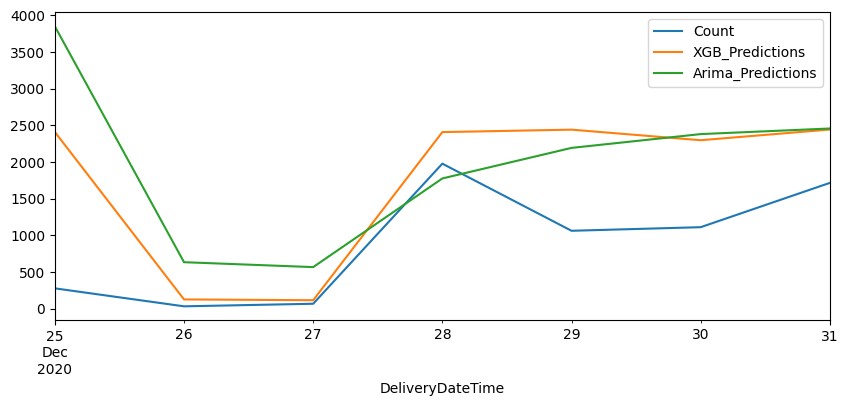

In [269]:
result_df.plot(figsize=(10,4))


# **Long Short - Term Memory (LSTM)**

In [270]:
# define parameters
verbose, epochs, batch_size = 1, 100, 10
n_timesteps, n_features, n_outputs = train_X_lstm.shape[1], train_X_lstm.shape[2], train_Y_lstm.shape[1]

In [271]:
n_timesteps, n_features, n_outputs


(1, 7, 1)

In [376]:
# define model
lstm_model = Sequential()
lstm_model.add(Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(n_timesteps, n_features)))

In [377]:
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
# lstm_model.add(RepeatVector(n_outputs))
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))  # Adding Dropout layer
lstm_model.add(TimeDistributed(Dense(1, activation='relu')))
#lstm_model.add(TimeDistributed(Dense(1)))
#lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001))
lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['acc'])

In [378]:
train_X_lstm.shape, train_Y_lstm.shape


((352, 1, 7), (352, 1, 1))

In [379]:
%%time
history = lstm_model.fit(train_X_lstm, train_Y_lstm, epochs=epochs, batch_size=batch_size, validation_data=(test_X_lstm, test_Y_lstm),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose, shuffle=False)

lstm_model.summary()


Epoch 1/100
36/36 [==============================] - 4s 29ms/step - loss: 0.2083 - acc: 0.0085 - val_loss: 0.0942 - val_acc: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0615 - acc: 0.0369 - val_loss: 0.0871 - val_acc: 0.0000e+00
Epoch 3/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0366 - acc: 0.0398 - val_loss: 0.1071 - val_acc: 0.0000e+00
Epoch 4/100
36/36 [==============================] - 1s 16ms/step - loss: 0.0263 - acc: 0.0398 - val_loss: 0.1229 - val_acc: 0.0000e+00
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0242 - acc: 0.0398 - val_loss: 0.1088 - val_acc: 0.0000e+00
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 0.0222 - acc: 0.0398 - val_loss: 0.1168 - val_acc: 0.0000e+00
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0200 - acc: 0.0398 - val_loss: 0.1221 - val_acc: 0.0000e+00
Epoch 8/100
36/36 [=============================

In [380]:
# Predict results with LSTM Model
lstm_predicts = lstm_model.predict(test_X_lstm, verbose=verbose)

1/1 [==============================] - 0s 334ms/step


In [381]:
# Invert scaled predictons to time series
predictions = list()
start = 7 # test period
l = len(test_scaled) - start

lstm_rmse = []
lstm_mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-7:] # ts_window

    X1 = X1.reshape((1,-1))

    yhat = invert_scale(scaler, X1[0], lstm_predicts[i][0])

    l=l+1

    #yhat = inverse_difference(delivery_count['Count'], yhat, len(test_scaled) + 1 - i)

    predictions.append(yhat)

    lstm_rmse.append(sqrt(mean_squared_error([delivery_count['Count'][-7:][i]], [yhat])))
    lstm_mape.append(mean_absolute_percentage_error([delivery_count['Count'][-7:][i]], [yhat]))

<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-4f4aa734b5af>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row = [float(x) for x in new_row]  # Convert to float if needed
<ipython-input-250-

In [382]:
print("LSTM RMSE:", np.mean(lstm_rmse))
print("LSTM MAPE:", np.mean(lstm_mape))

LSTM RMSE: 1075.350821497362
LSTM MAPE: 372.34926650147196


LSTM RMSE: 893.0953700555935

LSTM MAPE: 329.83148111907843
####


LSTM RMSE: 1011.772666041178

LSTM MAPE: 344.9847476052535
#####

LSTM RMSE: 1030.967931129365

LSTM MAPE: 388.99412056000875
####

LSTM RMSE: 1293.050945124988

LSTM MAPE: 498.693010507614
###

LSTM RMSE: 981.7580409513914

LSTM MAPE: 897.7088839901373

In [383]:
result_df['LSTM_Predictions'] = predictions
result_df.head(9)

<ipython-input-383-4d2b9972ee58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['LSTM_Predictions'] = predictions


,Count,XGB_Predictions,Arima_Predictions,LSTM_Predictions
DeliveryDateTime,,,,
2020-12-25,277,2409.002137,3849.687251,3331.833995
2020-12-26,32,126.113285,633.609543,14.000000
2020-12-27,67,115.104109,566.689449,834.759687
2020-12-28,1977,2407.403110,1775.528696,2313.736325
2020-12-29,1062,2440.827553,2192.122100,2521.595180
2020-12-30,1111,2296.751177,2380.193831,2270.328711
2020-12-31,1715,2442.471285,2456.487452,2446.201853


<Axes: xlabel='DeliveryDateTime'>

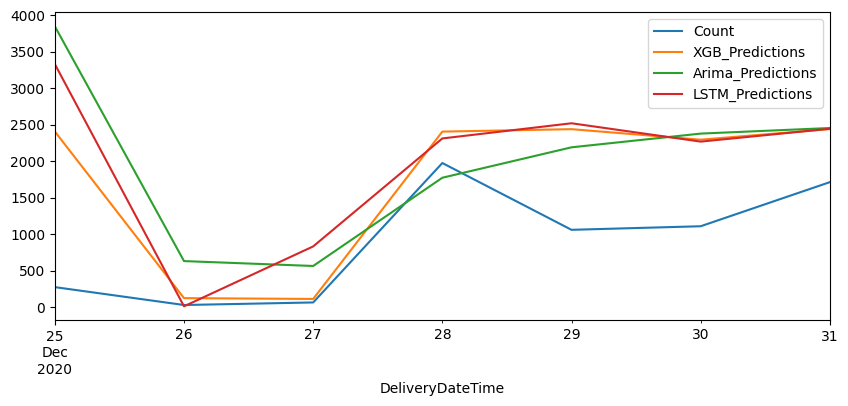

In [384]:
result_df.plot(figsize=(10,4))


In [385]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)

In [386]:
result_df.columns

Index(['Count', 'XGB_Predictions', 'Arima_Predictions', 'LSTM_Predictions'], dtype='object')

In [387]:
print('Actual count :', result_df.Count.sum())
print('XGB count :', result_df.XGB_Predictions.sum())
print('ARIMA count :', result_df.Arima_Predictions.sum())
print('LSTM count :', result_df.LSTM_Predictions.sum())

Actual count : 6241
XGB count : 12237.672656935181
ARIMA count : 13854.318319834816
LSTM count : 13732.455750481533
